In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import IPython.display as display
import pandas
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
import numpy as np
import PIL.Image
import time
import functools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
tf.config.list_physical_devices('GPU')
#tf.__version__

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
content_path="/content/drive/My Drive/nst_horse_2.jpg"
style_path = "/content/drive/My Drive/nst_edtaonisl.jpg"

In [ ]:
def layer_extractor(layers):
    cnn=tf.keras.applications.VGG19(top=False, weights='imagenet')
    cnn.trainable=False
    outputs=[cnn.get_layer(layer_name).output for layer_name in layers]
    model=tf.keras.Model([cnn.input],outputs)
    return model

In [ ]:
def load_image(image_path):
    i=tf.io.read_file(image_path)
    #print(type(i)," i1")
    i=tf.image.decode_image(i,channels=3)
    #print(type(i)," i2")
    i=tf.image.convert_image_dtype(i,np.float32)
    #print(type(i)," i3")
    #print(tf.shape(i))
    shape=tf.cast(tf.shape(i)[:-1],tf.float32)
    #print(shape," sha")
    largest_dimension=max(shape)
    scale=512/largest_dimension
    shape2=tf.cast(shape*scale,tf.int32)
    #print(shape2," sh2")
    i=tf.image.resize(i,shape2)
    i=i[tf.newaxis,:]
    return i

In [ ]:
def show_image(img,title=None):
    if len(img.shape)>3:
        tf.squeeze(img,axis=0)
    img=img[0]
    plt.imshow(img)
    if title!=None:
        plt.title(title)

In [ ]:
from google.colab import files
files

<module 'google.colab.files' from '/usr/local/lib/python3.6/dist-packages/google/colab/files.py'>

In [ ]:
content_img=load_image(content_path)
style_img=load_image(style_path)

(1, 512, 512, 3)


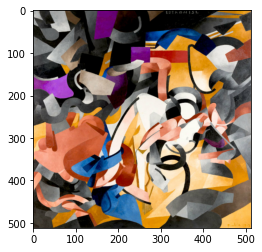

In [ ]:
print(style_img.shape)
show_image(style_img)

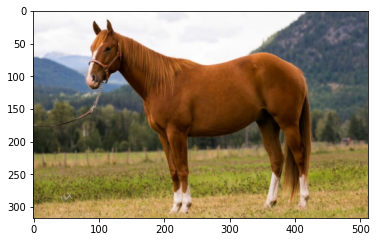

In [ ]:
show_image(content_img)

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg=VGG19(include_top=False,weights='imagenet')
#for i in vgg.layers():
#    print(i.name)

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
#number and types of layers in the vgg19 model
for l in vgg.layers:
    print(l.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
content_capturing_layers=['block5_conv2']
style_capturing_layers=['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

In [ ]:
#define a model from keras functional api which resemble to the already trained VGG19 
from tensorflow.keras.applications.vgg19 import VGG19
def model_(layer_names):
    vgg=VGG19(include_top="False",weights='imagenet')
    vgg.trainable='False'
    layer_outputs=[vgg.get_layer(name).output for name in layer_names]
    model=tf.keras.Model([vgg.input],layer_outputs)
    return model

In [ ]:
style_extracting_model=model_(style_capturing_layers)
#tf.image.resize(style_img,[224,224], preserve_aspect_ratio=False,antialias=False, name=None)
style_outputs=style_extracting_model(style_img*255)
for name, output in zip(style_capturing_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

574717952/574710816 [==============================] - 9s 0us/step
block1_conv1
  shape:  (1, 512, 512, 64)
  min:  0.0
  max:  835.2343
  mean:  28.683659

block2_conv1
  shape:  (1, 256, 256, 128)
  min:  0.0
  max:  5335.6577
  mean:  158.86896

block3_conv1
  shape:  (1, 128, 128, 256)
  min:  0.0
  max:  11079.524
  mean:  187.89711

block4_conv1
  shape:  (1, 64, 64, 512)
  min:  0.0
  max:  17357.02
  mean:  708.96576

block5_conv1
  shape:  (1, 32, 32, 512)
  min:  0.0
  max:  2998.2734
  mean:  62.907944



In [ ]:
#gram matrix for calculating style function;
def gram_matrix(input_tensor_value):
    result=tf.linalg.einsum('bijc,bijd->bcd',input_tensor_value,input_tensor_value)
    dimensions=tf.shape(input_tensor_value)
    mean=tf.cast(dimensions[1]*dimensions[2],tf.float32)
    return result/mean

In [ ]:
class style_content_model(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(style_content_model, self).__init__()
        self.vgg = model_(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
    def call(self,inputs):
        inputs=inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}


In [ ]:
extractor = style_content_model(style_capturing_layers, content_capturing_layers)
results = extractor(tf.constant(content_img))

style_results = results['style']

print('Style_results')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Content_results")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Style_results
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.04087083
    max:  31755.914
    mean:  374.8436

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  54483.574
    mean:  10291.977

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.62778634
    max:  298425.66
    mean:  10413.44

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  2509033.8
    mean:  157640.77

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  135124.08
    mean:  1492.9332

Content_results
   block5_conv2
    shape:  (1, 19, 32, 512)
    min:  0.0
    max:  1870.1458
    mean:  14.420781


In [ ]:
style_targets=extractor(style_img)['style']
content_targets=extractor(content_img)['content']

image=tf.Variable(content_img)


In [ ]:
#clipping function for the image
def clip_0_1(image):
    return tf.clip_by_value(image,clip_value_min=0.0,clip_value_max=1.0)

In [ ]:
opt=tf.optimizers.Adam(learning_rate=0.02,beta_1=0.09,epsilon=1e-1)

style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs=outputs['style']
    content_outputs=outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / len(style_capturing_layers)

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight / len(content_capturing_layers)
    loss = style_loss + content_loss
    return loss

In [ ]:
def train_step(image):
    with tf.GradientTape() as tape:
      outputs = extractor(image)
      loss = style_content_loss(outputs)

      grad = tape.gradient(loss, image)
      opt.apply_gradients([(grad, image)])
      image.assign(clip_0_1(image))

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

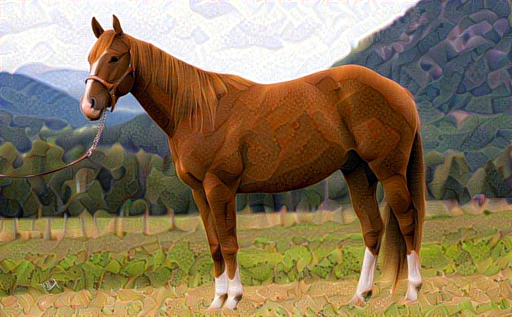

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [ ]:

content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 0us/step


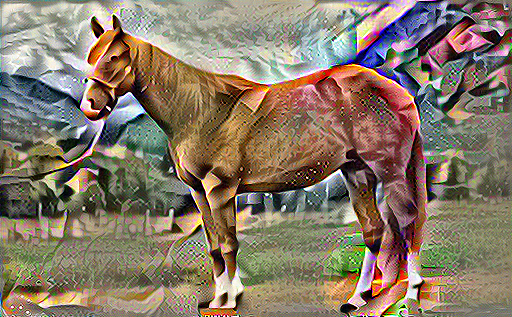

Train step: 2000
Total time: 218.7


In [ ]:
import time
start = time.time()

epochs = 20
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
image.shape

TensorShape([1, 317, 512, 3])

In [ ]:
tf.keras.preprocessing.image.save_img('/content/drive/My Drive/nst_result.png',image[0])